<a href="https://colab.research.google.com/github/jingwoo4710/2020_project/blob/main/Week1_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## geopandas 설치
# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express

In [3]:
#Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr, spearmanr
import branca.colormap as cm
import folium
import geopandas as gpd

plt.style.use('dark_background')

In [2]:
# Fucntion 
def summing_axis (df):
  traits = ['OPN','CSN','EXT','AGR','EST']
  for trait in traits:
    df[trait] = df[[col for col in df.columns if trait in col]].sum(axis = 1)
  return df[traits+['country']]
  

In [4]:
# COVID19 Data Import
corona_df = pd.read_csv('WHO-COVID-19-global-data.csv')

In [5]:
# Header 확인
corona_df.head(2)

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-03,AF,Afghanistan,EMRO,0,0,0,0
1,2020-01-04,AF,Afghanistan,EMRO,0,0,0,0


In [6]:
# header 공백 제거
cols = corona_df.columns.to_list()
corona_df.columns = [element.strip() for element in cols]
corona_df.head(2)

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-03,AF,Afghanistan,EMRO,0,0,0,0
1,2020-01-04,AF,Afghanistan,EMRO,0,0,0,0


In [7]:
# 나라별 총 확진자수
df_covid = corona_df.groupby(['Country', 'Country_code']).sum().rename_axis(['Country', 'Country_code']).reset_index()
df_covid = df_covid.iloc[:,:3]
df_covid.head()

,Country,Country_code,New_cases
0,Afghanistan,AF,39422
1,Albania,AL,14410
2,Algeria,DZ,52270
3,American Samoa,AS,0
4,Andorra,AD,2370


In [8]:
# Big 5 성격테스트에서 Postive 와 Negative 문제 나누기 + 필요한 열 정의
pos_questions = [
    'OPN1','OPN3','OPN5','OPN7','OPN8','OPN9','OPN10',        # 7 개방성
    'CSN1','CSN3','CSN5','CSN7','CSN9','CSN10',               # 6 성실성
    'EXT1','EXT3','EXT5','EXT7','EXT9',                       # 5 외향성
    'AGR2','AGR4','AGR6','AGR8','AGR9','AGR10',               # 6 친화성
    'EST1','EST3','EST5','EST6','EST7','EST8','EST9','EST10', # 8 안정성(신경성)
]

neg_questions = [
    'OPN2','OPN4','OPN6',                # 3 개방성
    'CSN2','CSN4','CSN6','CSN8',         # 4 성실성
    'EXT2','EXT4','EXT6','EXT8','EXT10', # 5 외향성
    'AGR1','AGR3','AGR5','AGR7',         # 4 친화성
    'EST2','EST4',                       # 2 안정성(신경성)
]

use_cols = pos_questions + neg_questions + ['country']

In [9]:
# Big Five Personality Test Import 
trait = pd.read_csv('data-final.csv', sep = '\t', usecols=use_cols)

In [10]:
# Header, Size 확인
print(trait.head(2))
print(trait.size)

   EXT1  EXT2  EXT3  EXT4  EXT5  EXT6  ...  OPN6  OPN7  OPN8  OPN9  OPN10  country
0   4.0   1.0   5.0   2.0   5.0   1.0  ...   1.0   5.0   3.0   4.0    5.0       GB
1   3.0   5.0   3.0   4.0   3.0   3.0  ...   1.0   4.0   2.0   5.0    3.0       MY

[2 rows x 51 columns]
51782391


In [11]:
# 값이 0인 경우 NaN 처리 + 해당 row 삭제
trait = trait.replace(0,np.NaN).dropna(axis = 0).reset_index(drop = True)

In [12]:
# Country Name이 None 인 경우 삭제
i = trait.loc[trait.country == 'NONE'].index
trait.drop(i, inplace= True)

In [13]:
# 사이즈와 header 확인
print(trait.size)
trait.head(2)

43998210


,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,country
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,5.0,2.0,4.0,2.0,3.0,2.0,4.0,3.0,4.0,3.0,4.0,3.0,2.0,2.0,4.0,4.0,2.0,4.0,4.0,5.0,1.0,4.0,1.0,4.0,1.0,5.0,3.0,4.0,5.0,GB
1,3.0,5.0,3.0,4.0,3.0,3.0,2.0,5.0,1.0,5.0,2.0,3.0,4.0,1.0,3.0,1.0,2.0,1.0,3.0,1.0,1.0,4.0,1.0,5.0,1.0,5.0,3.0,4.0,5.0,3.0,3.0,2.0,5.0,3.0,3.0,1.0,3.0,3.0,5.0,3.0,1.0,2.0,4.0,2.0,3.0,1.0,4.0,2.0,5.0,3.0,MY


In [14]:
# 데이터의 크기가 충분한(= 1000 ) 나라만 추출
filtered_countries = pd.DataFrame(data = trait.groupby('country').agg('size').loc[trait.groupby('country').agg('size') > 1000])
filtered_countries = filtered_countries.index.to_list()

In [15]:
# 포함된 나라와 포함되지 않은 나라 분류
trait_use = trait.loc[trait.country.isin(filtered_countries)].reset_index()
trait_no_use = trait.loc[~trait.country.isin(filtered_countries)].reset_index(drop = True)
trait.iloc[:5,:11]

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,1.0
1,3.0,5.0,3.0,4.0,3.0,3.0,2.0,5.0,1.0,5.0,2.0
2,2.0,3.0,4.0,4.0,3.0,2.0,1.0,3.0,2.0,5.0,4.0
3,2.0,2.0,2.0,3.0,4.0,2.0,2.0,4.0,1.0,4.0,3.0
4,3.0,3.0,3.0,3.0,5.0,3.0,3.0,5.0,3.0,4.0,1.0


In [16]:
# 최소 500개이상의 데이터
filtered_no_use_country = trait_no_use.groupby('country').size().loc[trait_no_use.groupby('country').size() > 500].index.to_list()
trait_no_use = trait_no_use.loc[trait_no_use.country.isin(filtered_no_use_country)]

In [17]:
# 평균 계산을 위해 negative question 점수 scale 바꾸기
trait_use[neg_questions] = trait_use[neg_questions].apply(lambda x: 6 - x)
trait_no_use[neg_questions] = trait_no_use[neg_questions].apply(lambda x: 6 - x)

In [18]:
# 같은 유형의 문항의 점수 총 합치기
df = trait_use.copy()
df_no_use = trait_no_use.copy()

In [19]:
df_traits = summing_axis(df)
df_traits_no_use = summing_axis(df_no_use)

In [20]:
# 나라별로 mean 구하기
mean_df = df_traits.groupby('country').mean().rename_axis('Code').reset_index()
mean_df.head()

,Code,OPN,CSN,EXT,AGR,EST
0,AE,37.639791,34.032090,30.261933,37.917770,31.475732
1,AR,40.133075,31.678530,28.345068,36.416248,32.381431
2,AT,40.836251,32.518538,29.899588,36.876931,29.856334
3,AU,38.551472,33.626061,29.937915,37.918328,30.393272
4,BE,39.308450,32.029262,29.967453,37.661989,30.598089


In [21]:
mean_df_no_use = df_traits_no_use.groupby('country').mean().rename_axis('Code').reset_index()
mean_df_no_use.head()

,Code,OPN,CSN,EXT,AGR,EST
0,CR,39.633028,32.664220,28.759633,35.908257,31.051376
1,EC,38.383138,31.910352,29.119530,35.337247,31.806830
2,EE,38.964045,32.362921,28.283146,35.783146,30.279775
3,EG,37.943890,33.007481,28.480050,36.966334,33.011222
4,IS,39.057728,32.614525,30.225326,37.696462,30.463687


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

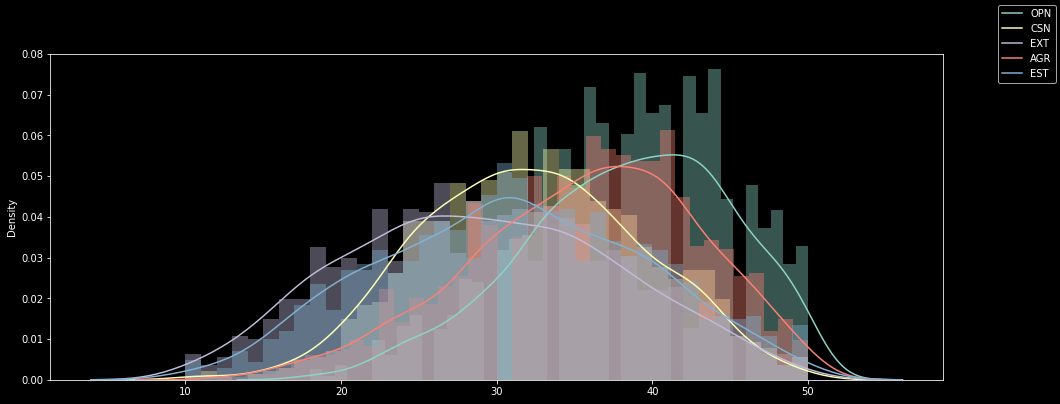

In [22]:
# 한국 성격테스트 결과
fig = plt.figure(figsize=(16, 6))
traits = ['OPN','CSN','EXT','AGR','EST']
for trait in traits:
  sns.distplot(df_traits[df_traits['country'] == 'KR'][trait], bins=40, axlabel=False)

fig.legend(traits)

In [23]:
# Filtering Country
df_covid = df_covid.loc[df_covid['Country_code'].isin(filtered_countries)]
df_covid.head()

,Country,Country_code,New_cases
8,Argentina,AR,798486
11,Australia,AU,27149
12,Austria,AT,49886
19,Belgium,BE,132109
28,Brazil,BR,4915289


In [24]:
# Big 5 성격테스트와 COVID19 데이터 합치기
df_covid.columns = ['Country', 'Code', 'New_cases']
df_covid = df_covid.merge(mean_df, on = 'Code')
df_covid.head()

,Country,Code,New_cases,OPN,CSN,EXT,AGR,EST
0,Argentina,AR,798486,40.133075,31.678530,28.345068,36.416248,32.381431
1,Australia,AU,27149,38.551472,33.626061,29.937915,37.918328,30.393272
2,Austria,AT,49886,40.836251,32.518538,29.899588,36.876931,29.856334
3,Belgium,BE,132109,39.308450,32.029262,29.967453,37.661989,30.598089
4,Brazil,BR,4915289,40.536946,31.240467,26.505017,34.946725,31.545703


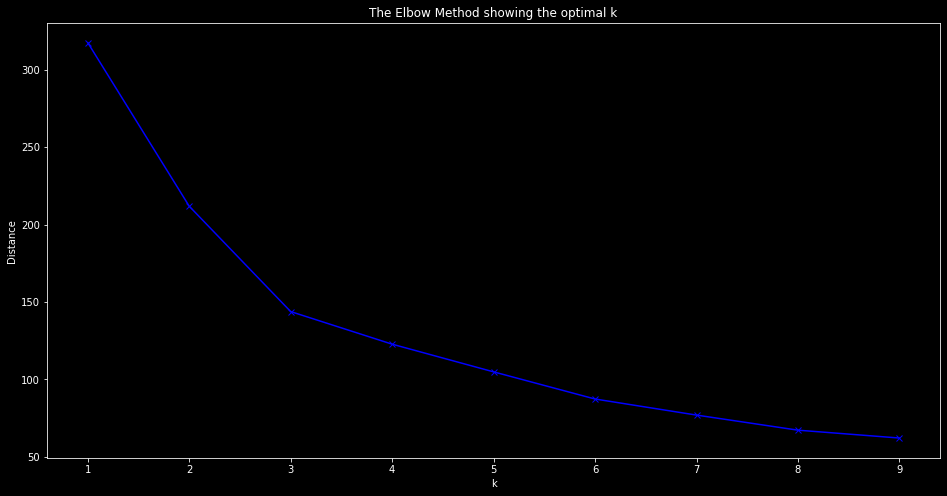

In [26]:
# K-means clustering 전 elbow plot 확인
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_covid.iloc[:,3:8])
    distortions.append(kmeanModel.inertia_)
   

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distance')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [27]:
#k = 3로 설정
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_covid.iloc[:,3:8])
df_covid['label'] = kmeans.labels_
df_covid.head()

,Country,Code,New_cases,OPN,CSN,EXT,AGR,EST,label
0,Argentina,AR,798486,40.133075,31.678530,28.345068,36.416248,32.381431,1
1,Australia,AU,27149,38.551472,33.626061,29.937915,37.918328,30.393272,0
2,Austria,AT,49886,40.836251,32.518538,29.899588,36.876931,29.856334,0
3,Belgium,BE,132109,39.308450,32.029262,29.967453,37.661989,30.598089,0
4,Brazil,BR,4915289,40.536946,31.240467,26.505017,34.946725,31.545703,1


In [28]:
# label별 case 확인
df_covid.loc[df_covid.label == 0]

,Country,Code,New_cases,OPN,CSN,EXT,AGR,EST,label
1,Australia,AU,27149,38.551472,33.626061,29.937915,37.918328,30.393272,0
2,Austria,AT,49886,40.836251,32.518538,29.899588,36.876931,29.856334,0
3,Belgium,BE,132109,39.308450,32.029262,29.967453,37.661989,30.598089,0
6,Canada,CA,166156,39.237147,33.752232,29.557088,37.870115,30.659691,0
12,Denmark,DK,30057,39.624273,32.612635,30.871571,37.781380,30.394431,0
20,Ireland,IE,38551,39.552102,32.750438,30.004597,37.695271,31.145578,0
21,Israel,IL,264805,41.083536,33.291971,30.030819,37.085158,30.138686,0
24,Kenya,KE,39449,39.364964,36.367701,28.346715,39.477190,29.748175,0
27,Netherlands,NL,140321,39.647772,33.056223,30.983607,37.799931,29.167975,0
29,Norway,NO,14457,39.353212,33.725625,30.853373,37.831385,29.752226,0


In [29]:
df_covid.loc[df_covid.label == 1]

,Country,Code,New_cases,OPN,CSN,EXT,AGR,EST,label
0,Argentina,AR,798486,40.133075,31.678530,28.345068,36.416248,32.381431,1
4,Brazil,BR,4915289,40.536946,31.240467,26.505017,34.946725,31.545703,1
5,Bulgaria,BG,21870,40.389388,32.484712,28.957734,35.624101,31.051259,1
7,Chile,CL,471746,39.998914,31.696526,28.559718,36.999457,31.738871,1
9,Colombia,CO,855052,38.895562,31.960294,29.139473,35.873874,31.959626,1
10,Croatia,HR,17797,40.079114,32.482068,29.061709,35.797996,30.574367,1
11,Czechia,CZ,85566,39.670317,31.677233,28.497406,35.527954,31.287032,1
13,Finland,FI,10702,39.696498,31.717250,28.020493,35.145525,31.083528,1
14,France,FR,598058,40.871051,32.003880,28.815260,36.968964,31.292444,1
15,Germany,DE,303258,41.064345,32.262837,28.638238,36.261473,30.133023,1


In [30]:
df_covid.loc[df_covid.label == 2]

,Country,Code,New_cases,OPN,CSN,EXT,AGR,EST,label
8,China,CN,91170,36.453737,33.510676,30.095196,37.660142,29.822954,2
18,India,IN,6685082,37.675013,34.043672,30.108281,37.456148,30.925174,2
19,Indonesia,ID,307120,37.138058,32.897995,27.954625,35.891664,31.709989,2
23,Japan,JP,86047,38.216888,32.449971,29.534991,36.128976,30.325043,2
25,Malaysia,MY,12813,34.485457,33.113003,28.601095,36.270903,31.720381,2
28,New Zealand,NZ,1502,37.840518,33.105907,30.304062,37.408018,30.304683,2
30,Pakistan,PK,315260,36.418073,34.409074,30.096363,38.664417,31.778403,2
32,Philippines,PH,324762,36.259472,34.214388,28.235612,36.492746,32.128897,2
39,Singapore,SG,57819,36.591807,33.079186,28.391894,36.836146,31.158806,2
44,Thailand,TH,3600,36.688630,33.443732,29.647230,36.282799,29.543440,2


In [32]:
# 결과가 좋지 않음 지나치게 outlier 인 미국과 인도를 빼자
i = df_covid.loc[(df_covid.Country == 'India') | (df_covid.Country == 'United States of America')].index
df_covid.drop(i, inplace=True)

In [33]:
# Label 별로 그룹
res_df = df_covid.loc[:, ['New_cases', 'label'] + traits ].groupby('label').mean().rename_axis('label').reset_index()
res_df = res_df.apply(lambda x: x.round(2))
res_df = res_df.sort_values('New_cases', ascending=False).reset_index(drop=True)
res_df

,label,New_cases,OPN,CSN,EXT,AGR,EST
0,1,544949.14,39.92,32.09,28.54,35.84,31.62
1,0,202716.53,39.76,33.33,30.00,37.64,30.24
2,2,118265.73,36.73,33.33,29.16,36.85,31.05


In [34]:
# filtered country 에 속하지 않은 나라들의 데이터 예측
mean_df_no_use['label'] = kmeans.predict(mean_df_no_use.iloc[:,1:])
mean_df_no_use.head()

,Code,OPN,CSN,EXT,AGR,EST,label
0,CR,39.633028,32.664220,28.759633,35.908257,31.051376,1
1,EC,38.383138,31.910352,29.119530,35.337247,31.806830,1
2,EE,38.964045,32.362921,28.283146,35.783146,30.279775,1
3,EG,37.943890,33.007481,28.480050,36.966334,33.011222,2
4,IS,39.057728,32.614525,30.225326,37.696462,30.463687,0


In [ ]:
# Plot

In [36]:
# Geometry
countries = gpd.read_file('python/99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp')

DriverError: ignored

In [ ]:
countries.head(2)

,OBJECTID,CNTRY_NAME,geometry
0,1,Aruba,"POLYGON ((-69.88223 12.41111, -69.94695 12.436..."
1,2,Antigua and Barbuda,"MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ..."


In [ ]:
corona_df.head(2)

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-03,AF,Afghanistan,EMRO,0,0,0,0
1,2020-01-04,AF,Afghanistan,EMRO,0,0,0,0


In [ ]:
# 열 이름 통일
countries = countries.rename(columns={'CNTRY_NAME': 'Country'})

In [ ]:
corona_df = corona_df[corona_df.New_cases != 0]

In [ ]:
corona_df = corona_df.replace({'Country' : 'Republic of Korea'}, 'South Korea')

corona_df = corona_df.replace({'Country' : 'United States of America'}, 'United States')

corona_df = corona_df.replace({'Country' : 'Venezuela (Bolivarian Republic of)'}, 'Venezuela')

corona_df = corona_df.replace({'Country' : 'Bolivia (Plurinational State of)'}, 'Bolivia')

corona_df = corona_df.replace({'Country' : 'Russian Federation'}, 'Russia')

corona_df = corona_df.replace({'Country' : 'Iran (Islamic Republic of)'}, 'Iran')

corona_df = corona_df.replace({'Country' : 'Viet Nam'}, 'Vietnam')

corona_df = corona_df.replace({'Country' : "Lao People's Democratic Republic"}, 'Laos')

corona_df = corona_df.replace({'Country' : "Syrian Arab Republic"}, 'Syria')

corona_df = corona_df.replace({'Country' : "United Republic of Tanzania"}, 'Tanzania')

corona_df = corona_df.replace({'Country' : "Democratic Republic of the Congo"}, 'Congo')

corona_df = corona_df.replace({'Country' : 
                      dict.fromkeys(['Taiwan', 
                                     'Mainland China', 
                                     'Hong Kong', 
                                     'Macau'], 
                                     'China')})
corona_df = corona_df.replace({'Country' : 'The United Kingdom'}, 
                                'United Kingdom')
corona_df = corona_df.replace({'Country' : 'North Ireland'}, 
                                'United Kingdom')
corona_df = corona_df.replace({'Country' : 'Republic of Ireland'}, 
                                'Ireland')
corona_df = corona_df.replace({'Country' : 'Vatican City'}, 
                                'Italy')
countries = countries.replace({'Country' : 'Byelarus'}, 
                               'Belarus')
countries = countries.replace({'Country' : 'Macedonia'}, 
                               'North Macedonia')
countries = countries.replace({'Country' : 'Myanmar (Burma)'}, 
                               'Myanmar')
countries = countries.replace({'Country' : 'Tanzania, United Republic of'}, 
                               'Tanzania')

In [ ]:
sorted_df = corona_df.sort_values(['Country', 
                     'Date_reported']).reset_index(drop=True)
sorted_df.head(2)                     

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-02-24,AF,Afghanistan,EMRO,5,5,0,0
1,2020-03-07,AF,Afghanistan,EMRO,3,8,0,0


In [ ]:
sum_df = sorted_df.groupby(['Country', 'Date_reported'], as_index=False).sum()
sum_df.head()

,Country,Date_reported,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,Afghanistan,2020-02-24,5,5,0,0
1,Afghanistan,2020-03-07,3,8,0,0
2,Afghanistan,2020-03-11,3,11,0,0
3,Afghanistan,2020-03-14,3,14,0,0
4,Afghanistan,2020-03-15,6,20,0,0


In [ ]:
joined_df = sum_df.merge(countries, on='Country')
joined_df.head(2)

,Country,Date_reported,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,OBJECTID,geometry
0,Afghanistan,2020-02-24,5,5,0,0,3,"POLYGON ((61.27656 35.60725, 61.29638 35.62853..."
1,Afghanistan,2020-03-07,3,8,0,0,3,"POLYGON ((61.27656 35.60725, 61.29638 35.62853..."


In [ ]:
joined_df['log_Confirmed'] = np.log10(joined_df['New_cases'])

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
joined_df['date_sec'] = pd.to_datetime(joined_df['Date_reported']).astype(int) / 10**9
joined_df['date_sec'] = joined_df['date_sec'].astype(int).astype(str)

In [ ]:
joined_df.head(2)

,Country,Date_reported,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,OBJECTID,geometry,log_Confirmed,date_sec
0,Afghanistan,2020-02-24,5,5,0,0,3,"POLYGON ((61.27656 35.60725, 61.29638 35.62853...",0.698970,1582502400
1,Afghanistan,2020-03-07,3,8,0,0,3,"POLYGON ((61.27656 35.60725, 61.29638 35.62853...",0.477121,1583539200


In [ ]:
joined_df = joined_df[['Country', 'date_sec', 'log_Confirmed', 'geometry']]
joined_df.head(2)

,Country,date_sec,log_Confirmed,geometry
0,Afghanistan,1582502400,0.698970,"POLYGON ((61.27656 35.60725, 61.29638 35.62853..."
1,Afghanistan,1583539200,0.477121,"POLYGON ((61.27656 35.60725, 61.29638 35.62853..."


In [ ]:
joined_df = joined_df.dropna()

In [ ]:
max_colour = max(joined_df['log_Confirmed'])
min_colour = min(joined_df['log_Confirmed'])
cmap = cm.linear.YlOrRd_09.scale(min_colour, max_colour)
cmap
joined_df['colour'] = joined_df['log_Confirmed'].map(cmap)

In [ ]:
country_list = joined_df['Country'].unique().tolist()
country_idx = range(len(country_list))

style_dict = {}
for i in country_idx:
    country = country_list[i]
    result = joined_df[joined_df['Country'] == country]
    inner_dict = {}
    for _, r in result.iterrows():
        inner_dict[r['date_sec']] = {'color': r['colour'], 'opacity': 0.7}
    style_dict[str(i)] = inner_dict

In [ ]:
countries_df = joined_df[['geometry']]
countries_gdf = gpd.GeoDataFrame(countries_df)
countries_gdf = countries_gdf.drop_duplicates().reset_index()

In [ ]:
from folium.plugins import TimeSliderChoropleth

slider_map = folium.Map(min_zoom=2, max_bounds=True,tiles='cartodbpositron')

_ = TimeSliderChoropleth(
    data=countries_gdf.to_json(),
    styledict=style_dict,

).add_to(slider_map)

_ = cmap.add_to(slider_map)
cmap.caption = "Log of number of confirmed cases"
slider_map.save(outfile='Whole_Country.html')

In [ ]:
# Country Code
code = pd.read_csv('wikipedia-iso-country-codes.csv', usecols=['English short name lower case', 'Alpha-2 code'])
code.columns = ['Country', 'Code']
code.head(2)

,Country,Code
0,Afghanistan,AF
1,Åland Islands,AX


In [ ]:
# Country 이름
mean_df_no_use = mean_df_no_use.merge(code, on = 'Code')

In [ ]:
res_df

,label,New_cases,OPN,CSN,EXT,AGR,EST
0,2,665500.42,36.81,33.39,29.24,36.90,31.04
1,0,648884.62,39.72,33.38,29.99,37.68,30.25
2,1,544949.14,39.92,32.09,28.54,35.84,31.62


In [ ]:
mean_df_no_use.loc[mean_df_no_use.label == 0]

,Code,OPN,CSN,EXT,AGR,EST,label,Country
4,IS,39.057728,32.614525,30.225326,37.696462,30.463687,0,Iceland
5,LB,38.235465,34.341570,30.559593,37.918605,31.257267,0,Lebanon
8,NG,39.150721,36.436435,28.460026,39.263434,29.598952,0,Nigeria
9,PR,39.487078,33.304175,28.642147,37.194831,31.163022,0,Puerto Rico


In [ ]:
mean_df_no_use.loc[mean_df_no_use.label != res_df.iloc[2, 0]].Country

3            Egypt
4          Iceland
5          Lebanon
6        Sri Lanka
8          Nigeria
9      Puerto Rico
10    Saudi Arabia
13          Taiwan
Name: Country, dtype: object

In [ ]:
# 확진자수가 가장많은 분류군
label_0_country = mean_df_no_use.loc[mean_df_no_use.label != res_df.iloc[2, 0]].Country.unique().tolist()
label_0 = joined_df.loc[joined_df.Country.isin(label_0_country)].reset_index(drop=True)
label_0.head(2)


,Country,date_sec,log_Confirmed,geometry,colour
0,Costa Rica,1583625600,0.954243,"POLYGON ((-82.93047 9.06312, -82.88223 9.06722...",#ffe38aff
1,Costa Rica,1583712000,0.602060,"POLYGON ((-82.93047 9.06312, -82.88223 9.06722...",#ffeea2ff


In [ ]:
print(label_0_country)

['Costa Rica', 'Ecuador', 'Estonia', 'Iceland', 'Lebanon', 'Lithuania', 'Nigeria', 'Puerto Rico', 'Slovenia', 'Slovakia', 'Ukraine', 'Venezuela']


In [ ]:
max_colour = max(joined_df['log_Confirmed'])
min_colour = min(joined_df['log_Confirmed'])
cmap = cm.linear.YlOrRd_09.scale(min_colour, max_colour)
cmap
label_0['colour'] = label_0['log_Confirmed'].map(cmap)

In [ ]:
country_list = label_0['Country'].unique().tolist()
country_idx = range(len(country_list))

style_dict = {}
for i in country_idx:
    country = country_list[i]
    result = joined_df[joined_df['Country'] == country]
    inner_dict = {}
    for _, r in result.iterrows():
        inner_dict[r['date_sec']] = {'color': r['colour'], 'opacity': 0.7}
    style_dict[str(i)] = inner_dict

In [ ]:
countries_df = label_0[['geometry']]
countries_gdf = gpd.GeoDataFrame(countries_df)
countries_gdf = countries_gdf.drop_duplicates().reset_index()

In [ ]:
from folium.plugins import TimeSliderChoropleth

slider_map = folium.Map(min_zoom=2, max_bounds=True,tiles='cartodbpositron')

_ = TimeSliderChoropleth(
    data=countries_gdf.to_json(),
    styledict=style_dict,

).add_to(slider_map)

_ = cmap.add_to(slider_map)
cmap.caption = "Log of number of confirmed cases"
slider_map.save(outfile='Many.html')

In [ ]:
label_2_country = mean_df_no_use.loc[mean_df_no_use.label == res_df.iloc[2, 0]].Country.unique().tolist()
label_2 = joined_df.loc[joined_df.Country.isin(label_2_country)].reset_index(drop=True)
label_2.head(2)


,Country,date_sec,log_Confirmed,geometry,colour
0,Egypt,1581638400,0.69897,"POLYGON ((32.64902 29.78836, 32.60791 29.82361...",#ffeb9bff
1,Egypt,1583107200,0.00000,"POLYGON ((32.64902 29.78836, 32.60791 29.82361...",#ffffccff


In [ ]:
max_colour = max(joined_df['log_Confirmed'])
min_colour = min(joined_df['log_Confirmed'])
cmap = cm.linear.YlOrRd_09.scale(min_colour, max_colour)
cmap
label_2['colour'] = label_2['log_Confirmed'].map(cmap)
country_list = label_2['Country'].unique().tolist()
country_idx = range(len(country_list))

style_dict = {}
for i in country_idx:
    country = country_list[i]
    result = joined_df[joined_df['Country'] == country]
    inner_dict = {}
    for _, r in result.iterrows():
        inner_dict[r['date_sec']] = {'color': r['colour'], 'opacity': 0.7}
    style_dict[str(i)] = inner_dict

In [ ]:
countries_df = label_2[['geometry']]
countries_gdf = gpd.GeoDataFrame(countries_df)
countries_gdf = countries_gdf.drop_duplicates().reset_index()
from folium.plugins import TimeSliderChoropleth

slider_map = folium.Map(min_zoom=2, max_bounds=True,tiles='cartodbpositron')

_ = TimeSliderChoropleth(
    data=countries_gdf.to_json(),
    styledict=style_dict,

).add_to(slider_map)

_ = cmap.add_to(slider_map)
cmap.caption = "Log of number of confirmed cases"
slider_map.save(outfile='Less.html')